In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import DataLoader, Dataset
from scipy.special import gamma

# system related packages
from copy import deepcopy
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import sys
import re
import itertools

# customized packages
import group_dataset
import group_dataset_anchor
import dataset
import utils
from mlp import projector
from metricpref_learner import MetricPrefLearner, MetricPrefLearner_groups


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def val(learner,loss_fn,test_loader):
    total_val_samples = len(test_loader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)
            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples
    return val_stat

class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        return self.data_list[idx]
    
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    probabilities = logistic(targets * predictions)
    nll = -torch.sum(torch.log(probabilities))
    return nll

class frob_loss:
    def __init__(self, upper_bound=1, lmd=1):
        self.upper_bound = upper_bound
        self.lmd = lmd
    def calc_loss(self,w):
        return self.lmd*torch.clamp((torch.norm(w) - self.upper_bound),min=0)

class u_norm_loss:
    def __init__(self, lmd=1, feature_dim=1):
        # Mean and standard deviation of the chi distribution
        mu_chi = math.sqrt(2) * gamma((feature_dim + 1) / 2) / gamma(feature_dim / 2)
        sigma_chi = math.sqrt(feature_dim - mu_chi**2)
        # Mean and standard deviation of the scaled chi distribution
        mu_scaled = math.sqrt(1 / feature_dim) * mu_chi
        sigma_scaled = math.sqrt(1 / feature_dim) * sigma_chi
        self.upper_bound = mu_scaled + 2 * sigma_scaled
        self.lmd = lmd
    def calc_loss(self,us):
        return self.lmd * torch.mean(torch.clamp(torch.norm(us,dim=0) - self.upper_bound ,min=0))
    
# in order to keep using the same dataset
# we only initialize the dataset for one time
def get_dataset(args):
    ########### hyperparameters for the dataset ################
    feature_dim = args['feature_dim']
    metric_rank = args['metric_rank']
    num_items = args['num_items']
    num_users = args['num_users']
    num_pairs_per_user = args['num_pairs_per_user']
    noise_type = args['noise_type']
    noise_beta = args['noise_beta']
    num_groups = args['num_groups']
    normal_dataset = group_dataset_anchor.Dataset(dataset_type='Normal', d=feature_dim, 
                                            r=metric_rank, n=num_items, 
                                            N=num_users, m=num_pairs_per_user, 
                                            noise_type=noise_type, 
                                            noise_param=noise_beta, X=None,
                                            num_groups=num_groups)
    return normal_dataset

def oracle_pred(normal_dataset):
    # Oracle prediction (just for verification) original version
    normal_data = normal_dataset.getAllData()
    Y_noiseless = normal_dataset.Y_noiseless
    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
    delta_s = []
    pred_ys = []
    for obs in observations:
        user_id, comparison_pair = obs
        x_i, x_j = comparison_pair
        delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
        delta_s.append(delta)
        if delta > 0:
            pred_y = 1
        else:
            pred_y = -1
        pred_ys.append(pred_y)
    print('Oracle prediciton:', np.mean(pred_ys == true_y))
    return np.mean(pred_ys == Y_noiseless)



In [7]:


def train(learner,
          optimizer,
          loss_fn,
          train_loader,
          test_loader,
          epochs,
          penalty_net_loss_fn=None,
          penalty_us_loss_fn=None,
          relative_error_ind=True, 
          true_M=None, 
          true_u=None, 
          groups=None):
    
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
        'relative_weights_error_record': [],
        'train_delta_record': [],
        'train_penalty_frob_loss_per_batch_record': [],
        'train_penalty_us_loss_per_batch_record': [],
    }

    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            optimizer.zero_grad()
            pred_delta = learner(x)
            train_stats['train_delta_record'].append(pred_delta.detach().cpu().numpy())
            acc_batch = torch.sum((pred_delta * y)>0)
            # ############################ Evaluation part start #############################
            if relative_error_ind:
                # calculate the relative_metric_error
                L = learner.model.layers.weight
                relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
                train_stats['relative_metric_error_record'].append(relative_metric_error.item())
                # calculate the relative_ideal_point_error
                if groups:
                    us = learner.us_groups @ learner.softmax(learner.unconstrained_weights)
                    relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-us) / torch.norm(torch.tensor(true_u))).item()
                    train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
                else:
                    relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
                    train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            # ############################ Evaluation part end #############################
            loss = loss_fn(pred_delta,y)
            if penalty_net_loss_fn:
                L = learner.model.layers.weight
                penalty_net_loss = penalty_net_loss_fn.calc_loss(L.T @ L)
                train_stats['train_penalty_frob_loss_per_batch_record'].append(penalty_net_loss.item())
                loss += penalty_net_loss
            if penalty_us_loss_fn:
                if groups:
                    penalty_us_loss = penalty_us_loss_fn.calc_loss(learner.us_groups)
                else:
                    penalty_us_loss = penalty_us_loss_fn.calc_loss(learner.us)
                train_stats['train_penalty_us_loss_per_batch_record'].append(penalty_net_loss.item())
                loss += penalty_us_loss
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/len(y))
            loss.backward()
            optimizer.step()
        val_stat = val(learner,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats


def train_main(args, normal_dataset, relative_error_ind=True):
    ########### hyperparameters for the dataset ################
    feature_dim = args['feature_dim']
    metric_rank = args['metric_rank']
    num_items = args['num_items']
    num_users = args['num_users']
    samples_per_user = args['samples_per_user']
    num_groups = args['num_groups']
    set_groups = args['set_groups']
    ########### hyperparameters for the training ################
    # Notice: these hyperparameters are chosen by the grid_search experiments
    epochs = args['epochs'] #2000
    bs = args['bs']#64
    lr = args['lr']#0.005  # TODO: use different learning rate for us and net
    lr_us = args['lr_us']
    lr_net = args['lr_net']
    weight_decay_us = args['weight_decay_us']#0
    weight_decay_net = args['weight_decay_net']#0.001
    weight_decay_unconstrained_weight = args['weight_decay_unconstrained_weight']#0
    optimizer_name = args['optimizer_name']#'adam'
    penalty_net = args['penalty_net']
    penalty_us = args['penalty_us']
    ########### hyperparameters for the ablation experiments ################
    ablate_m = args['ablate_m']
    ablate_u = args['ablate_u']
    ablate_alpha = args['ablate_alpha']
    ########### initialize the dataloders ################
    normal_data = normal_dataset.getAllData()
    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
    obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=num_users*samples_per_user)
    ############ define dataloader ################
    train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
    ############ initialize the model and the learner################
    net = projector(feature_dim=feature_dim, num_layer=1, num_class=feature_dim, bias_ind=False)
    learner = MetricPrefLearner_groups(dim_feature=feature_dim, num_users=num_users, items=items, num_groups=set_groups)
    learner.assignModel(net)
    us_params = []
    net_params = []
    unconstrained_weights_params = []
    for name, param in learner.named_parameters():
        if 'us' in name:
            us_params.append(param)
        elif 'model' in name:
            net_params.append(param)
        elif 'unconstrained_weights' in name:
            if not ablate_alpha: unconstrained_weights_params.append(param)
    ############ define loss and optimizer ################
    if not ablate_alpha:
        weight_decay_dic = [
            {'params': us_params, 'weight_decay': weight_decay_us, 'lr': lr_us},
            {'params': net_params, 'weight_decay': weight_decay_net, 'lr': lr_net},
            {'params': unconstrained_weights_params, 'weight_decay': weight_decay_unconstrained_weight, 'lr': lr_us},
        ]
    else:
        weight_decay_dic = [
            {'params': us_params, 'weight_decay': weight_decay_us, 'lr': lr_us},
            {'params': net_params, 'weight_decay': weight_decay_net, 'lr': lr_us},
        ]
    loss_fn = hinge_loss
    penalty_net_loss_fn = frob_loss(upper_bound=feature_dim,lmd=penalty_net)
    penalty_us_loss_fn = u_norm_loss(lmd=penalty_us,feature_dim=feature_dim)
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(weight_decay_dic, betas=(0.9, 0.999), eps=1e-8)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(weight_decay_dic, momentum=0.9)

    # important modification: record the metric error
    # if num_groups:
    #     if args['set_groups'] == num_groups:
    #         train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
    #                         relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_u,groups=True,true_alpha=true_alpha)
    #     else:
    #         train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
    #                         relative_error_ind=False)
    # else:
    if set_groups:
        train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, penalty_net_loss_fn=penalty_net_loss_fn, penalty_us_loss_fn=penalty_us_loss_fn,
                        relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_u, groups=set_groups)
    else:
        train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, penalty_net_loss_fn=penalty_net_loss_fn, penalty_us_loss_fn=penalty_us_loss_fn,
                        relative_error_ind=relative_error_ind, true_M=true_M, true_u=true_u)

    return train_stats, learner







def _per_run(args, normal_dataset):
    print('current params:', args)
    train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)
    torch.save({'args':args, 'train_stats':train_stats, 'learner':learner}, f'./save_subgroups_new/subgroups_groups{args["set_groups"]}_ablatealpha{args["ablate_alpha"]}_exp1.pt')


In [8]:
args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 2,
        'set_groups': None,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

normal_dataset = get_dataset(args)
oracle_pred(normal_dataset)

Oracle prediciton: 1.0


1.0

In [9]:
args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 2,
        'set_groups': None,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

100%|██████████| 500/500 [00:13<00:00, 36.89it/s, test_accu=0.953]


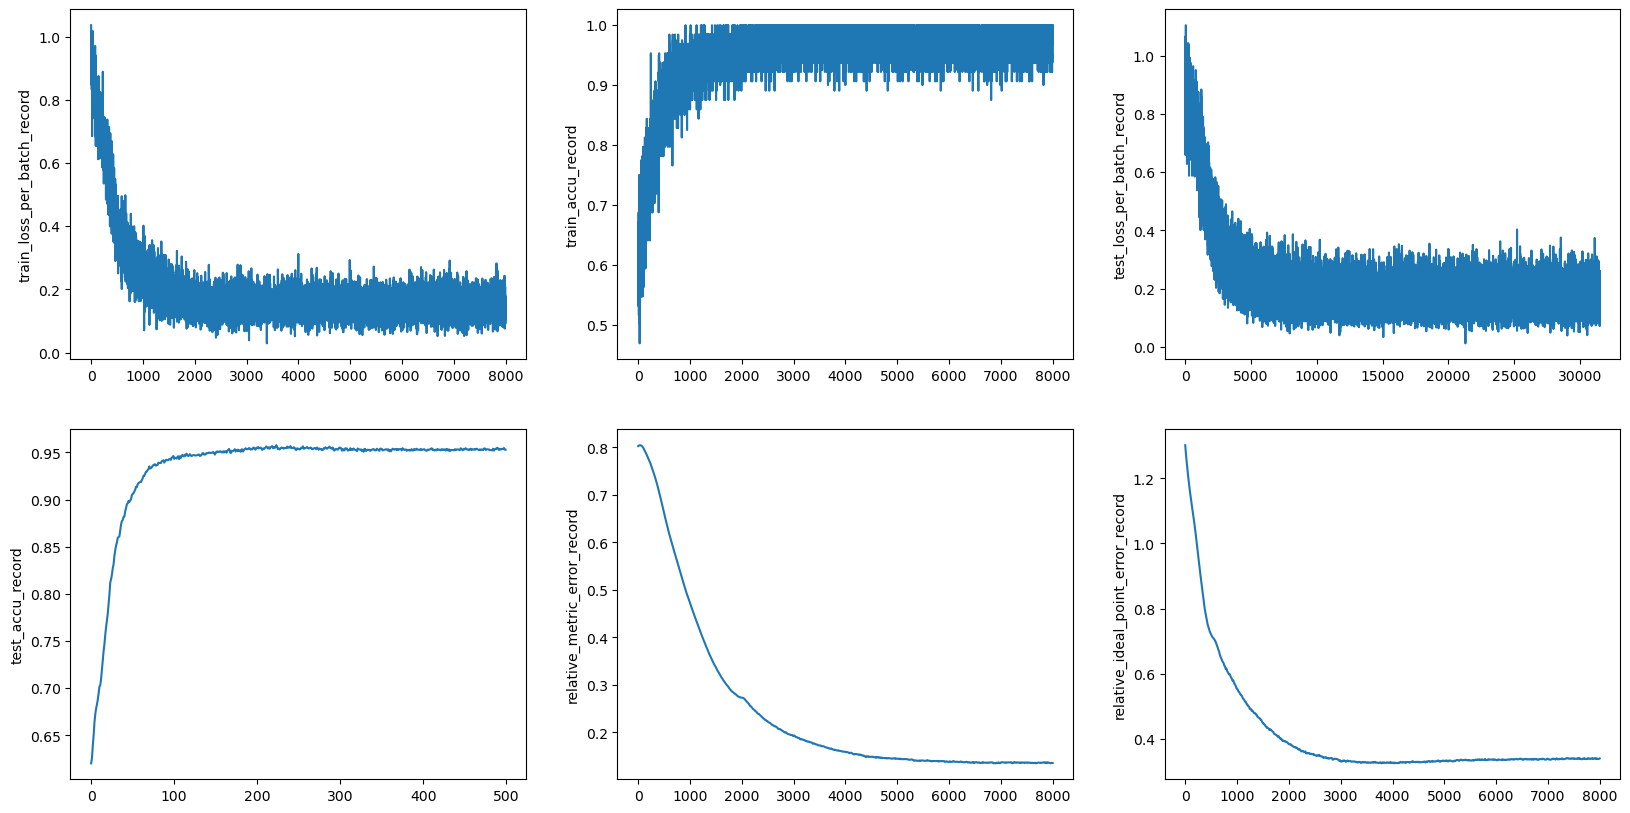

In [10]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [11]:
normal_dataset.M

array([[ 1.05467143,  0.52772155,  0.04996133],
       [ 0.52772155,  1.77686303, -0.30778721],
       [ 0.04996133, -0.30778721,  1.99474   ]])

In [12]:
L = learner.model.layers.weight
pred_M = L.T @ L
pred_M

tensor([[ 1.0998,  0.5405, -0.1433],
        [ 0.5405,  1.9453, -0.3651],
        [-0.1433, -0.3651,  1.7640]], grad_fn=<MmBackward0>)

In [28]:
normal_dataset.U

array([[-1.08720241, -1.08720241, -1.08720241,  0.79247791,  0.79247791,
         0.79247791, -1.08720241,  0.79247791,  0.79247791, -1.08720241],
       [ 0.80916129,  0.80916129,  0.80916129, -0.45190973, -0.45190973,
        -0.45190973,  0.80916129, -0.45190973, -0.45190973,  0.80916129],
       [ 0.14375496,  0.14375496,  0.14375496,  0.51618005,  0.51618005,
         0.51618005,  0.14375496,  0.51618005,  0.51618005,  0.14375496]])

In [14]:
learner.us

Parameter containing:
tensor([[-1.4765, -1.1838, -1.2869,  0.9151,  1.1076,  1.2643, -1.0663,  1.1710,
          1.3102, -1.1322],
        [ 0.8363,  0.8814,  1.0441, -0.4440, -0.5346, -0.6097,  0.8397, -0.5448,
         -0.5455,  0.6441],
        [ 0.0812,  0.0907,  0.3620,  0.8219,  0.7089,  0.9553,  0.1065,  0.7357,
          0.9339, -0.0042]], requires_grad=True)

In [38]:
import plotly.express as px
import pandas as pd

def plot3d_u(true_u,pred_u):
    ''' 
    true_u shape: (3,N) ndarray
    pred_u shape: (3,N) ndarray
    '''
    true_u_df1 = pd.DataFrame(true_u.T, columns=['column1', 'column2', 'column3'])
    pred_u_df2 = pd.DataFrame(pred_u.T, columns=['column1', 'column2', 'column3'])
    true_u_df1['source'] = 'true_u'
    pred_u_df2['source'] = 'pred_u'
    result_df = pd.concat([true_u_df1, pred_u_df2], ignore_index=True)
    fig = px.scatter_3d(result_df, x='column1', y='column2', z='column3', color='source')
    fig.show()

In [39]:
plot3d_u(normal_dataset.U, learner.us.detach().numpy())

In [74]:
# TODO: FIXME: the identifiability of U?
# our learner can learn the metric part very well. But why does the model can not well learn the u_s?

In [41]:
args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 2,
        'set_groups': 1,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

train_stats_one, learner_one = train_main(args, normal_dataset, relative_error_ind=True)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:13<00:00, 37.35it/s, test_accu=0.745]


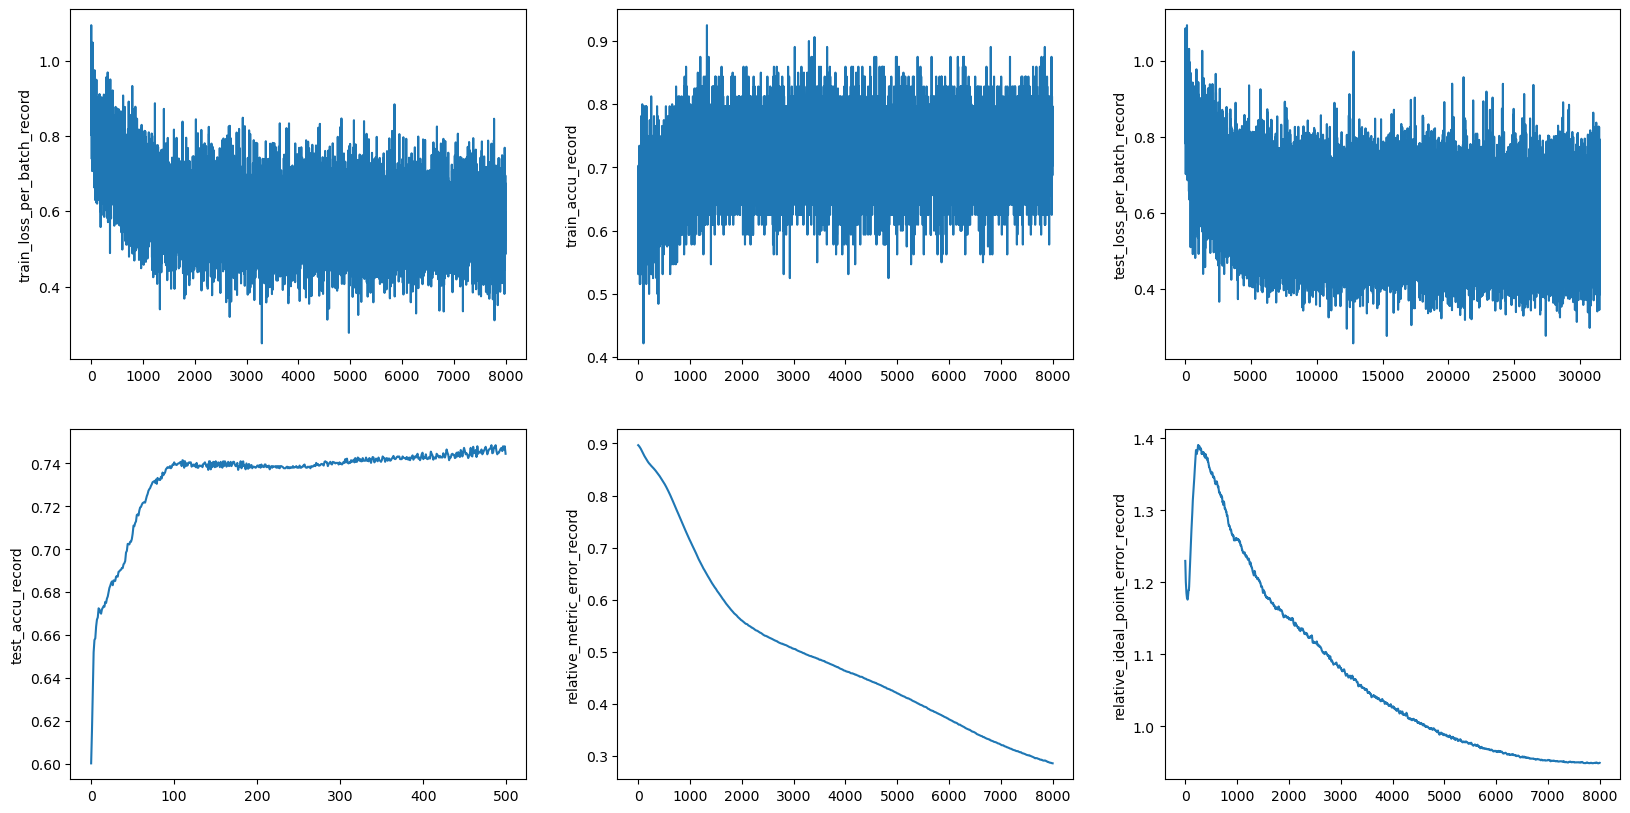

In [48]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats_one):
    ax_flatten[idx].plot(train_stats_one[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [45]:
plot3d_u(normal_dataset.U, 
         (learner_one.us_groups @ learner_one.softmax(learner_one.unconstrained_weights)).detach().numpy())

In [46]:
args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 2,
        'set_groups': 2,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

train_stats_two, learner_two = train_main(args, normal_dataset, relative_error_ind=True)

100%|██████████| 500/500 [00:13<00:00, 36.46it/s, test_accu=0.964]


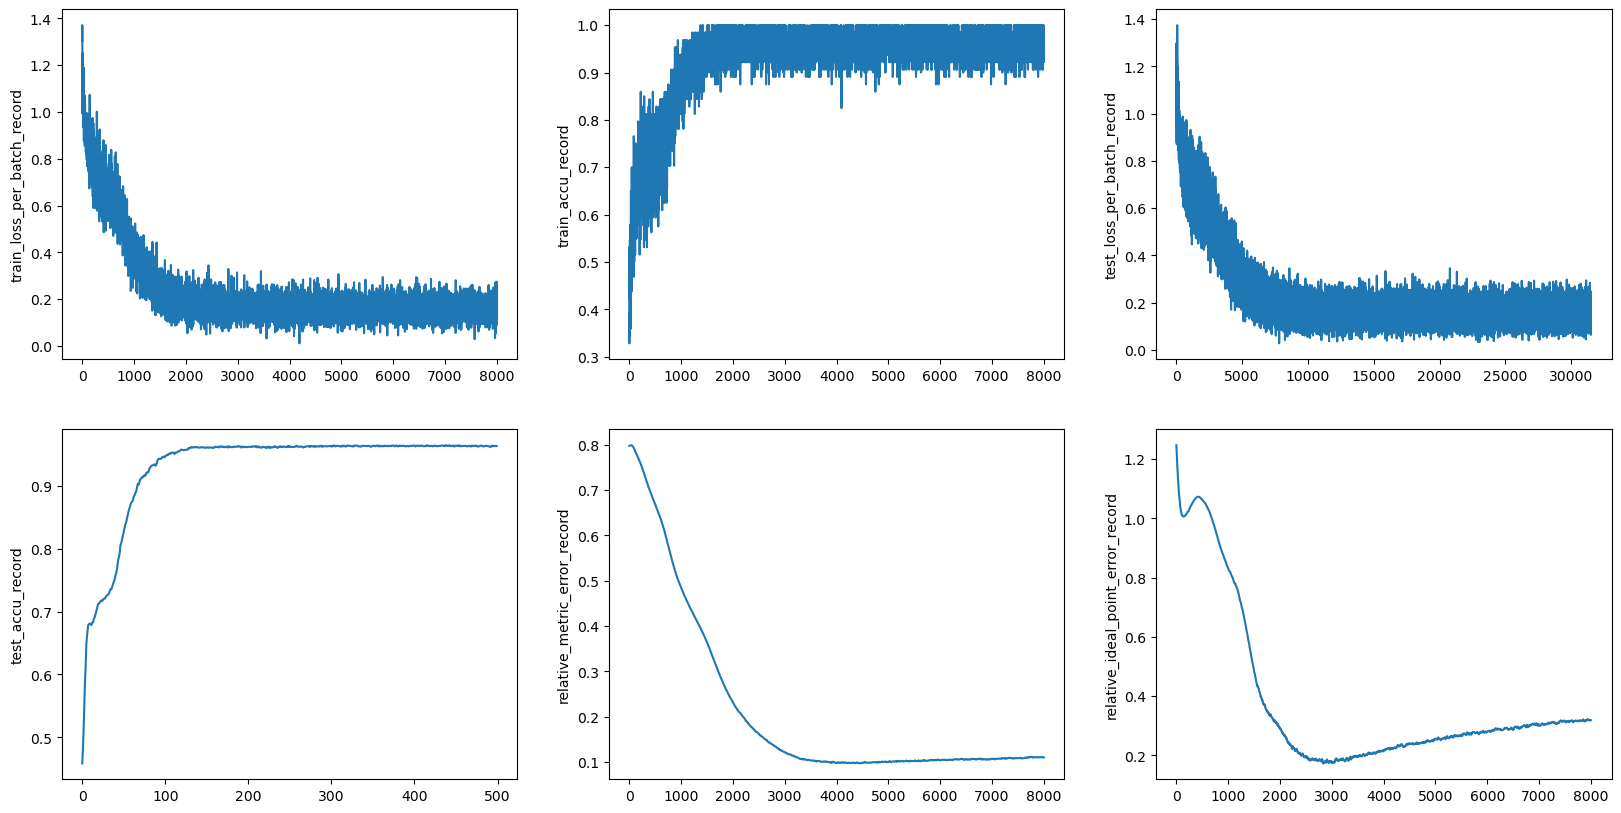

In [47]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats_two):
    ax_flatten[idx].plot(train_stats_two[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [49]:
plot3d_u(normal_dataset.U, 
         (learner_two.us_groups @ learner_two.softmax(learner_two.unconstrained_weights)).detach().numpy())

In [62]:
args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 2,
        'set_groups': 5,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

train_stats_5, learner_5 = train_main(args, normal_dataset, relative_error_ind=True)

100%|██████████| 500/500 [00:39<00:00, 12.56it/s, test_accu=0.952]


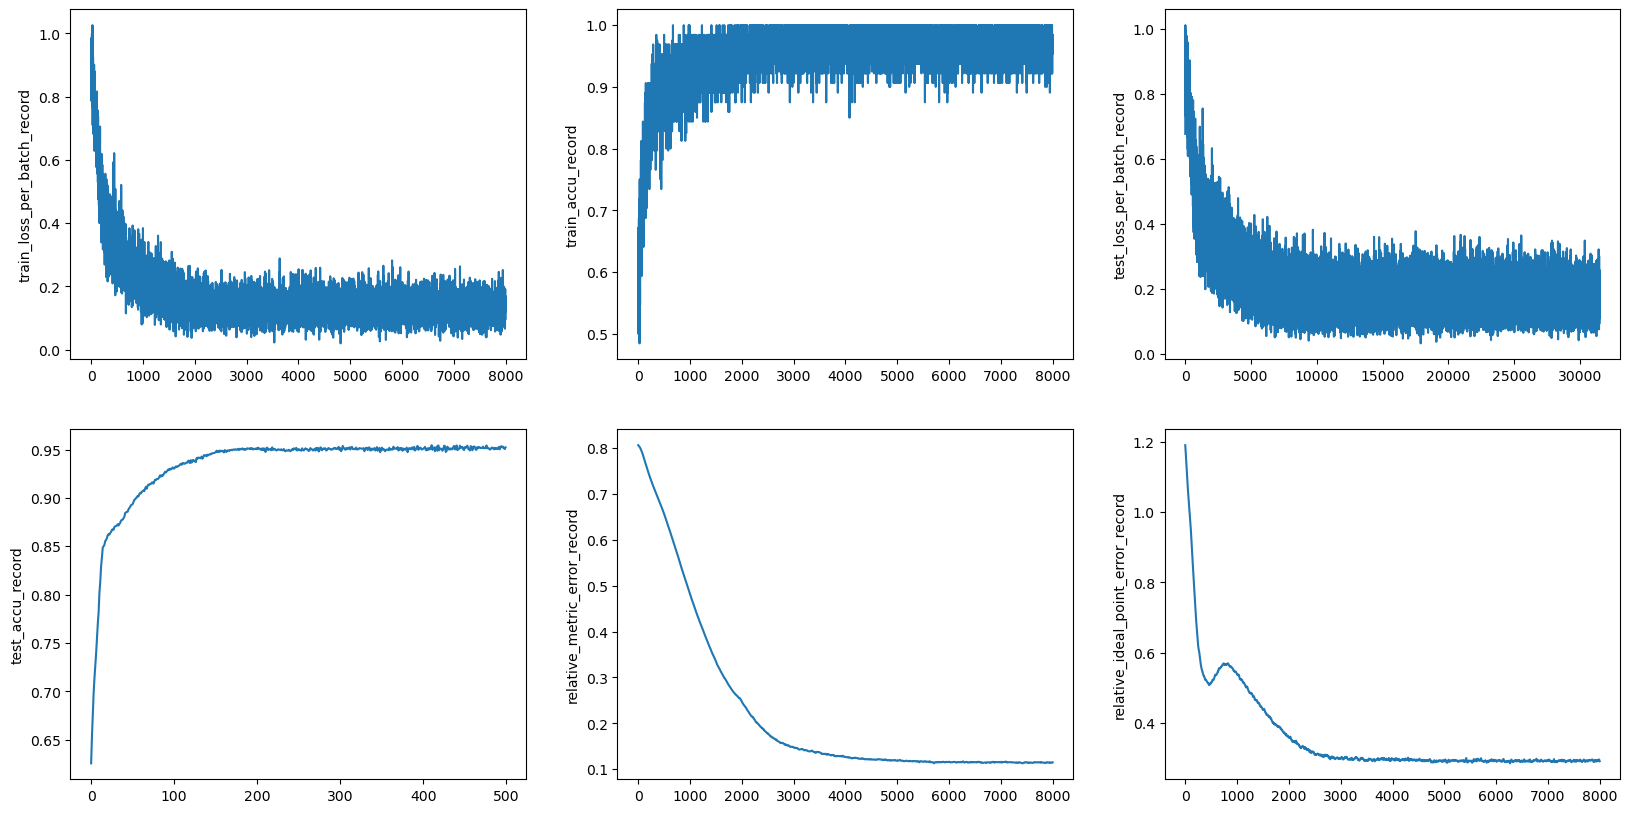

In [63]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats_5):
    ax_flatten[idx].plot(train_stats_5[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [64]:
plot3d_u(normal_dataset.U, 
         (learner_5.us_groups @ learner_5.softmax(learner_5.unconstrained_weights)).detach().numpy())

In [50]:
L = learner.model.layers.weight
pred_M = L.T @ L
pred_M

tensor([[ 1.0998,  0.5405, -0.1433],
        [ 0.5405,  1.9453, -0.3651],
        [-0.1433, -0.3651,  1.7640]], grad_fn=<MmBackward0>)

In [51]:
L = learner_one.model.layers.weight
pred_M = L.T @ L
pred_M

tensor([[ 0.7939,  0.5666,  0.0950],
        [ 0.5666,  1.3414, -0.1219],
        [ 0.0950, -0.1219,  1.3622]], grad_fn=<MmBackward0>)

In [59]:
L = learner_two.model.layers.weight
pred_M = L.T @ L
pred_M

tensor([[ 1.1181,  0.5082, -0.1233],
        [ 0.5082,  1.8545, -0.4026],
        [-0.1233, -0.4026,  1.8547]], grad_fn=<MmBackward0>)

In [58]:
L = learner_5.model.layers.weight
pred_M = L.T @ L
pred_M

tensor([[ 1.2869,  0.3879, -0.0915],
        [ 0.3879,  1.7024, -0.4657],
        [-0.0915, -0.4657,  1.9214]], grad_fn=<MmBackward0>)

In [53]:
normal_dataset.M

array([[ 1.05467143,  0.52772155,  0.04996133],
       [ 0.52772155,  1.77686303, -0.30778721],
       [ 0.04996133, -0.30778721,  1.99474   ]])

# test different set_groups

In [66]:
train_stats_list = []
learner_list = []
set_groups_list = np.arange(1,11)
for i in set_groups_list:
    args = {
            'feature_dim': 3,
            'metric_rank': 3,
            'num_items': 100,
            'num_users': 10,
            'num_pairs_per_user': 500,
            'samples_per_user': 100,
            'noise_type': 'none',
            'noise_beta': 3,
            'num_groups': 2,
            'set_groups': i,
            'epochs': 500,
            'bs': 64,
            'lr': 0.005,
            'lr_us': 0.005,
            'lr_net':0.0005,
            'weight_decay_us': 0,
            'weight_decay_net': 0.001,
            'weight_decay_unconstrained_weight': 0,
            'optimizer_name': 'adam',
            'ablate_alpha': False,
            'ablate_m': False,
            'ablate_u': False,
            'penalty_net': 0.1,
            'penalty_us': 0.1,
        }

    train_stats_tmp, learner_tmp = train_main(args, normal_dataset, relative_error_ind=True)
    train_stats_list.append(train_stats_tmp)
    learner_list.append(learner_tmp)

100%|██████████| 500/500 [00:14<00:00, 35.48it/s, test_accu=0.964]


Text(0, 0.5, 'test accuracy')

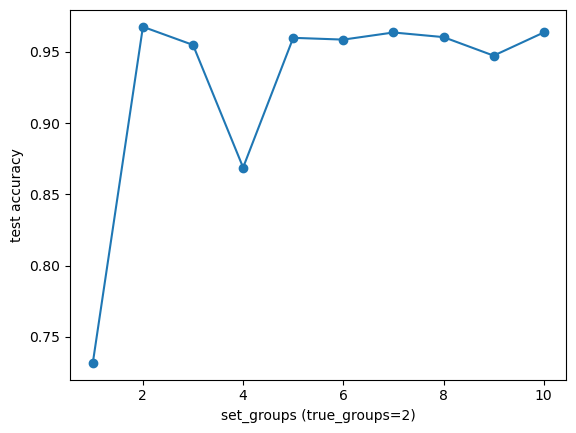

In [72]:
test_accu_list = [train_stats['test_accu_record'][-1] for train_stats in train_stats_list]
plt.plot(set_groups_list,test_accu_list,'-o')
plt.xlabel('set_groups (true_groups=2)')
plt.ylabel('test accuracy')

# test different groups (num_groups = 5)

In [86]:
args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 20,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 5,
        'set_groups': None,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

normal_dataset = get_dataset(args)
oracle_pred(normal_dataset)

Oracle prediciton: 1.0


1.0

In [87]:
train_stats_list = []
learner_list = []
set_groups_list = np.arange(1,11)
for i in set_groups_list:
    args = {
        'feature_dim': 3,
        'metric_rank': 3,
        'num_items': 100,
        'num_users': 20,
        'num_pairs_per_user': 500,
        'samples_per_user': 100,
        'noise_type': 'none',
        'noise_beta': 3,
        'num_groups': 5,
        'set_groups': i,
        'epochs': 500,
        'bs': 64,
        'lr': 0.005,
        'lr_us': 0.005,
        'lr_net':0.0005,
        'weight_decay_us': 0,
        'weight_decay_net': 0.001,
        'weight_decay_unconstrained_weight': 0,
        'optimizer_name': 'adam',
        'ablate_alpha': False,
        'ablate_m': False,
        'ablate_u': False,
        'penalty_net': 0.1,
        'penalty_us': 0.1,
    }

    train_stats_tmp, learner_tmp = train_main(args, normal_dataset, relative_error_ind=True)
    train_stats_list.append(train_stats_tmp)
    learner_list.append(learner_tmp)

100%|██████████| 500/500 [00:24<00:00, 20.16it/s, test_accu=0.941]


Text(0, 0.5, 'test accuracy')

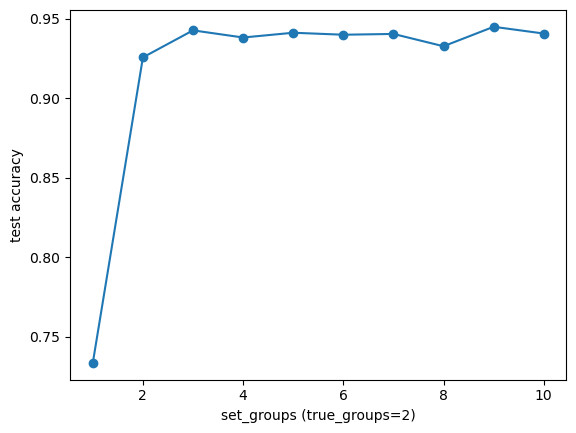

In [88]:
test_accu_list = [train_stats['test_accu_record'][-1] for train_stats in train_stats_list]
plt.plot(set_groups_list,test_accu_list,'-o')
plt.xlabel('set_groups (true_groups=2)')
plt.ylabel('test accuracy')

In [90]:
_tmp_learner = learner_list[1]

plot3d_u(normal_dataset.U, 
         (_tmp_learner.us_groups @ _tmp_learner.softmax(_tmp_learner.unconstrained_weights)).detach().numpy())

In [101]:
_tmp_learner = learner_list[4]

plot3d_u(normal_dataset.U, 
         (_tmp_learner.us_groups @ _tmp_learner.softmax(_tmp_learner.unconstrained_weights)).detach().numpy())

In [96]:
_tmp_learner = learner_list[4]

L = _tmp_learner.model.layers.weight
pred_M = L.T @ L
print(pred_M)

print(normal_dataset.M)

tensor([[ 0.8586, -1.0519,  0.1707],
        [-1.0519,  2.2658,  0.4778],
        [ 0.1707,  0.4778,  0.6330]], grad_fn=<MmBackward0>)
[[ 0.61450332 -1.01108413 -0.10494918]
 [-1.01108413  2.35012991  0.66195141]
 [-0.10494918  0.66195141  0.39535405]]


# check performance code

In [32]:
# check the performance

ds = normal_dataset
learner = learner

ds_data = ds.getAllData()
items, observations, true_y, true_M, true_u = ds_data['X'], ds_data['S'], ds_data['Y'], ds_data['M'], ds_data['U']
true_y_noiseless = normal_dataset.Y_noiseless


# oracle prediction
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == true_y_noiseless), "doesn't match!"


# prediction
L = learner.model.layers.weight
pred_M = L.T @ L
pred_M = pred_M.detach().cpu().numpy()
us = learner.us_groups @ learner.softmax(learner.unconstrained_weights)
us = us.detach().cpu().numpy()

delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-us[:,user_id]).T @ pred_M @ (items[:,x_i]-us[:,user_id]) - (items[:,x_j]-us[:,user_id]).T @ pred_M @ (items[:,x_j]-us[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)

print(np.mean(pred_ys == true_y_noiseless))

0.89632


In [ ]:
args['set_groups'] = 5
train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

In [277]:
args['penalty_net'] = 0
train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:25<00:00, 39.77it/s, test_accu=0.902]


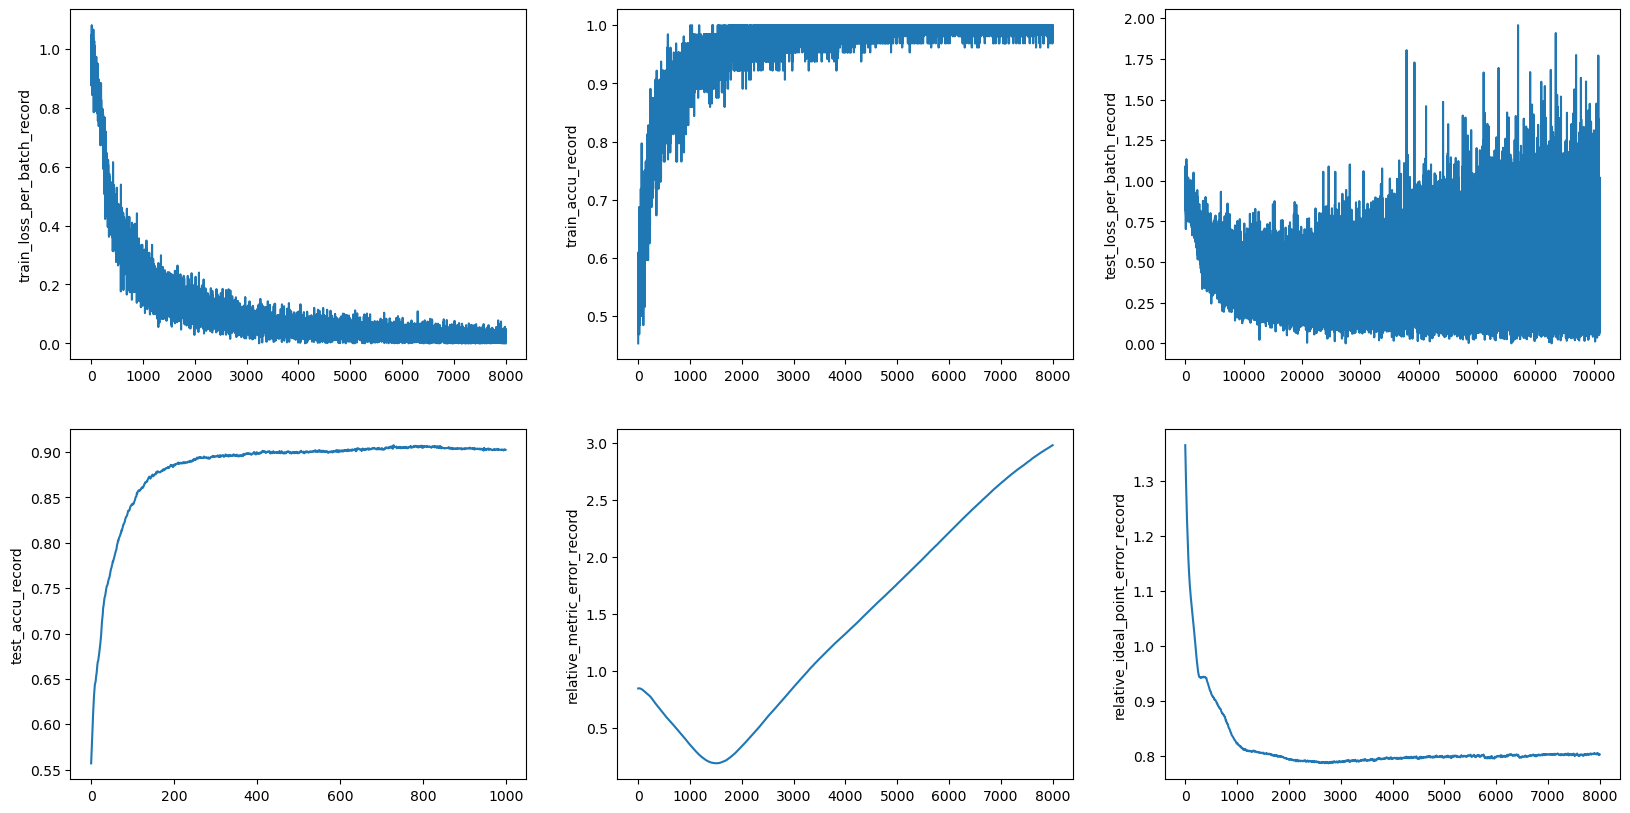

In [278]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [279]:
args['penalty_net'] = 1
train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:20<00:00, 47.65it/s, test_accu=0.876]


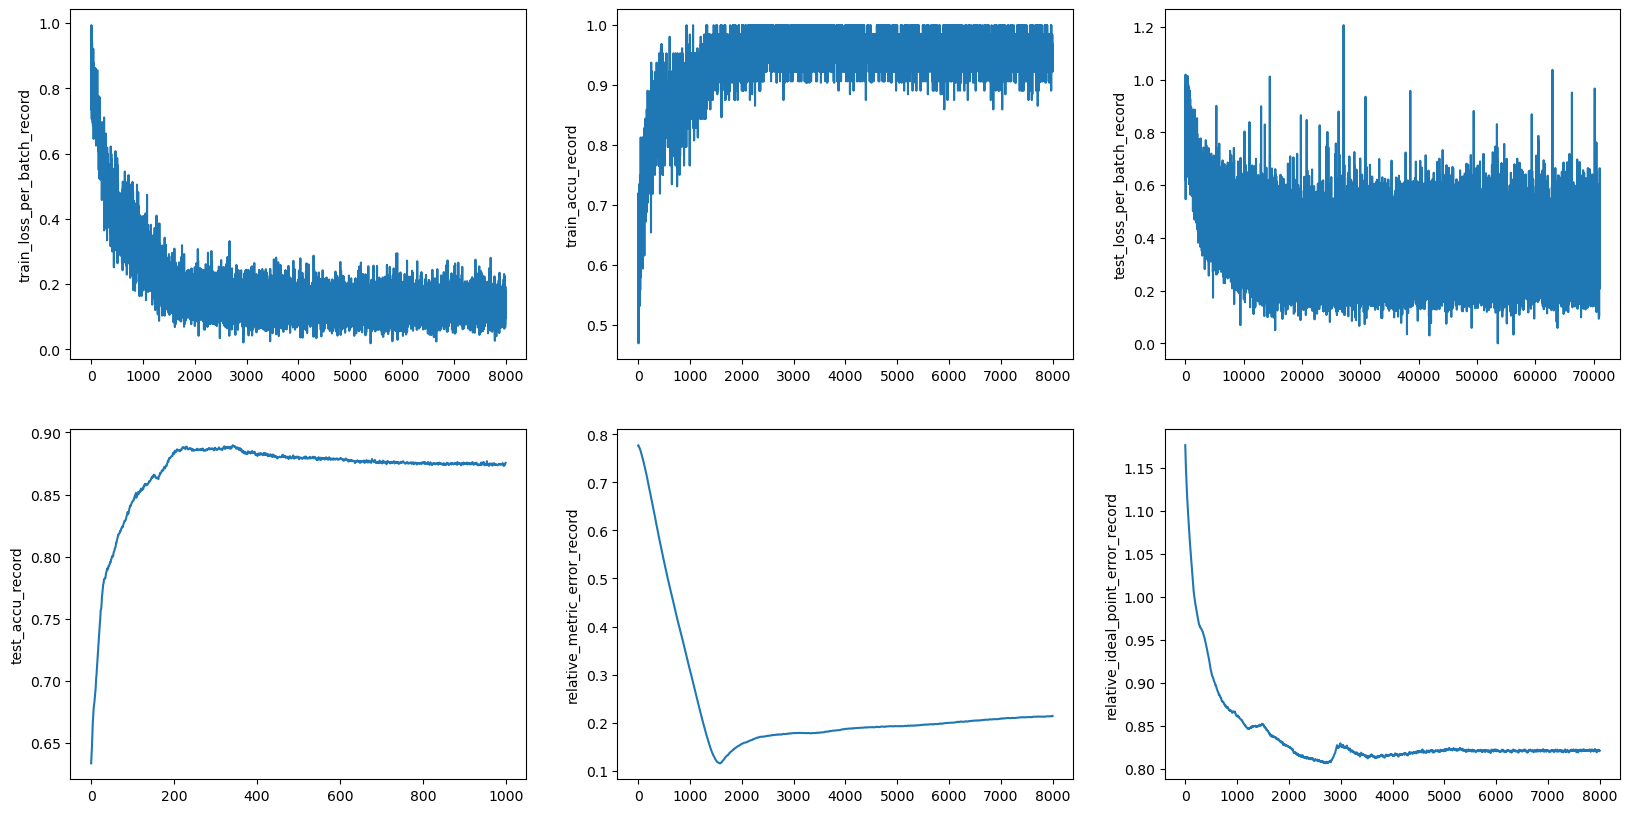

In [281]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [282]:
args['set_groups'] = 1
train_stats, learner = train_main(args, normal_dataset, relative_error_ind=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:18<00:00, 53.30it/s, test_accu=0.693]


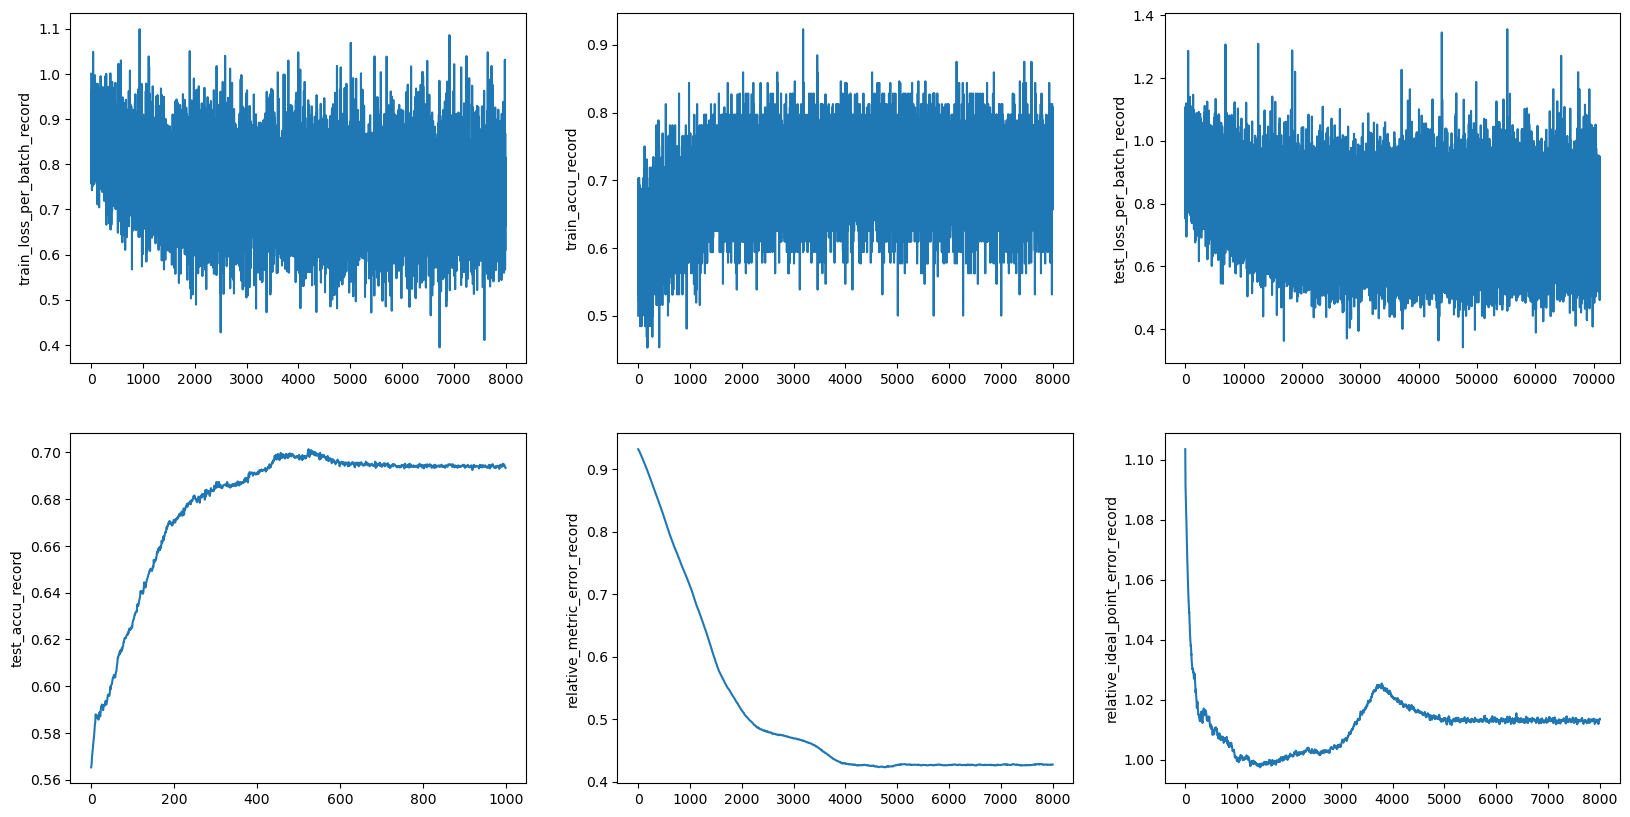

In [283]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)
    if idx == 5:
        break

In [151]:
args

{'feature_dim': 3,
 'metric_rank': 3,
 'num_items': 10000,
 'num_users': 50,
 'num_pairs_per_user': 100,
 'samples_per_user': 10,
 'noise_type': 'none',
 'noise_beta': 3,
 'num_groups': 3,
 'set_groups': 1,
 'epochs': 1000,
 'bs': 64,
 'lr': 0.005,
 'lr_us': 0.005,
 'lr_net': 0.0005,
 'weight_decay_us': 0,
 'weight_decay_net': 0.001,
 'weight_decay_unconstrained_weight': 0,
 'optimizer_name': 'adam',
 'ablate_alpha': False,
 'ablate_m': False,
 'ablate_u': False,
 'penalty_net': 1}

Text(0, 0.5, 'counts')

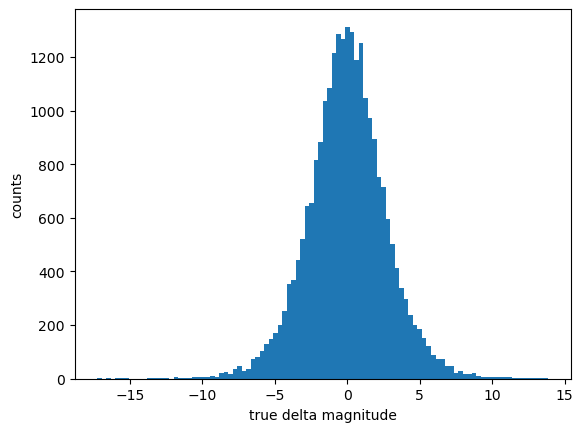

In [66]:
# plt.hist(np.concatenate(train_stats['train_delta_record']),bins=100)
plt.hist(normal_dataset.Y_unquant,bins=100)
plt.xlabel('true delta magnitude')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

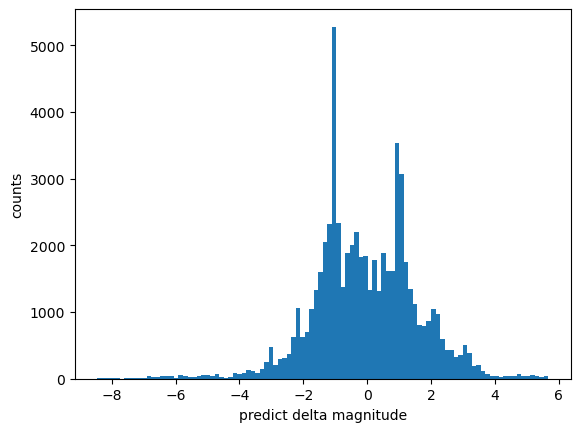

In [65]:
plt.hist(np.concatenate(train_stats['train_delta_record'][-1000:]),bins=100)
plt.xlabel('predict delta magnitude')
plt.ylabel('counts')

In [239]:
tmp1 = torch.tensor(np.random.multivariate_normal(np.zeros(3),(1/3)*np.eye(3),10000).T)

In [228]:
tmp2 = torch.randn((3,10000))

(array([  3.,   4.,  19.,  20.,  24.,  42.,  43.,  64.,  66.,  86., 106.,
        101., 124., 131., 153., 161., 206., 184., 174., 175., 213., 220.,
        243., 264., 251., 234., 237., 259., 282., 271., 254., 272., 246.,
        256., 224., 263., 236., 220., 245., 185., 210., 203., 211., 177.,
        174., 166., 203., 140., 151., 128., 119., 117., 114.,  95.,  91.,
         92.,  95.,  84.,  64.,  57.,  44.,  49.,  46.,  47.,  39.,  31.,
         34.,  33.,  30.,  22.,  21.,  19.,  12.,  15.,  10.,  18.,  11.,
         13.,  14.,   4.,   8.,   3.,   6.,   2.,   2.,   2.,   1.,   1.,
          1.,   1.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          2.]),
 array([0.05205025, 0.07766137, 0.1032725 , 0.12888362, 0.15449474,
        0.18010587, 0.20571699, 0.23132811, 0.25693923, 0.28255036,
        0.30816148, 0.3337726 , 0.35938373, 0.38499485, 0.41060597,
        0.4362171 , 0.46182822, 0.48743934, 0.51305047, 0.53866159,
        0.56427271, 0.58988384, 0.61549496, 0.

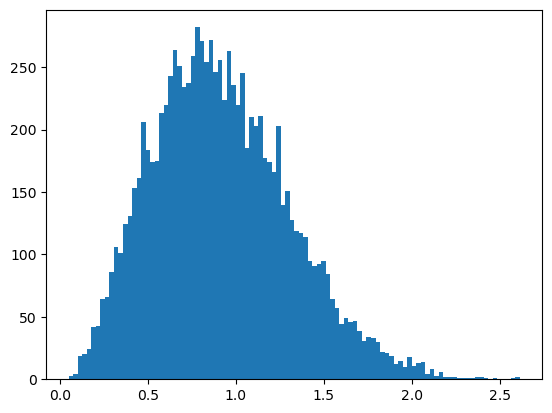

In [245]:
plt.hist(torch.norm(tmp1,dim=0).numpy(),bins=100)

(array([  5.,  10.,   9.,  12.,  28.,  45.,  39.,  50.,  62.,  73.,  78.,
         98., 114., 110., 144., 148., 154., 176., 186., 179., 226., 203.,
        228., 205., 206., 200., 234., 251., 243., 265., 239., 233., 234.,
        242., 224., 224., 223., 233., 230., 208., 210., 189., 215., 212.,
        169., 180., 194., 175., 145., 150., 144., 171., 104., 121., 111.,
        114.,  91.,  92.,  82.,  71.,  65.,  71.,  54.,  58.,  52.,  48.,
         46.,  36.,  48.,  24.,  30.,  36.,  24.,  22.,  20.,  13.,  18.,
         14.,   7.,  16.,  11.,   8.,  11.,  10.,   7.,   3.,   7.,   6.,
          3.,   4.,   3.,   2.,   2.,   0.,   3.,   2.,   1.,   1.,   1.,
          2.]),
 array([0.08892876, 0.13135557, 0.17378238, 0.21620919, 0.258636  ,
        0.30106282, 0.34348962, 0.3859164 , 0.42834324, 0.47077006,
        0.5131968 , 0.55562365, 0.5980505 , 0.6404773 , 0.6829041 ,
        0.7253309 , 0.7677577 , 0.81018454, 0.8526113 , 0.8950381 ,
        0.93746495, 0.9798918 , 1.0223186 , 1.

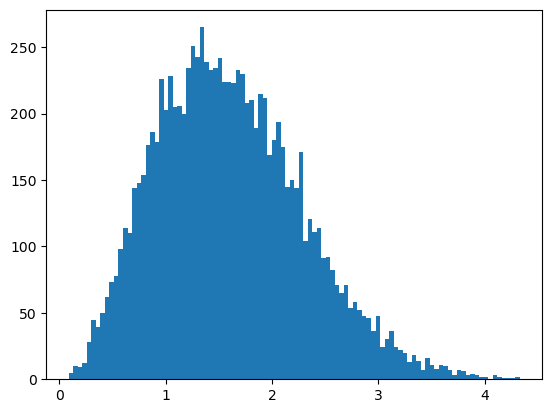

In [246]:
plt.hist(torch.norm(tmp2,dim=0).numpy(),bins=100)

In [247]:
from scipy.special import gamma
import math

# Degrees of freedom
N = 3  # Example value, can be any positive integer
# Scaling factor
d = 3  # Example value, can be any positive real number

# Mean and standard deviation of the chi distribution
mu_chi = math.sqrt(2) * gamma((N + 1) / 2) / gamma(N / 2)
sigma_chi = math.sqrt(N - mu_chi**2)

# Mean and standard deviation of the scaled chi distribution
mu_scaled = math.sqrt(1 / d) * mu_chi
sigma_scaled = math.sqrt(1 / d) * sigma_chi

mu_scaled, sigma_scaled


(0.9213177319235614, 0.3888105410649569)

In [261]:
torch.mean(torch.clamp(torch.norm(tmp1,dim=0) - 1,min=0))

tensor(0.1219, dtype=torch.float64)